# Computational Bionics: Project Exercise 1

Group members:
- Yash Waware
- Julian Lork
- Florian Frech (12308544)

## Task 1: Modeling the Leg

### 1.1 Description

The following section consider the model of the leg, described by an ODE model.

A test person with a body mass of $m_b = 100$ kg is chosen.

Following state variables are involved:
- $q_1$: Extension angle of the **hip** around then transversal axis ($xy$-plane)
- $\omega_1$: Angular velocity of the tight
- $q_2$: Rotation angle of the **knee** around the transversal axis ($xy$-plane) 
- $\omega_2$ Angular velocity of the shank

The segement masses are considered as point masses in the middle of each segment.

![](LegModel.png)

|Variable|Description|
|--------|-----------|
|$r_H$|Position vector of the hip to the reference system|
|$H$|Hip Joint|
|$K$|Knee Joint|
|$O$|Tigh|
|$U$|Shank|
|$S$|Centre of Mass of the Foot|
|$SO$|Centre of Mass of the Tigh|
|$SU$|Centre of Mass Shank|
|$m_1$|Tigh Mass|
|$m_2$|Shank Mass|
|$m_3$|Foot Point Mass|
|$J_1$|Moment of Inertia of the Tigh|
|$J_2$|Moment of Inertia of the Shank|
|$\alpha_H$|Flexion / Extension Angle of the Hip|
|$\alpha_K$|Flexion / Extension Angle of the Knee|


Following relations for the partial masses of the legs are assumed:

|Segment| Mass m [kg]|
|------|--------------|
|Tigh|  $m_1 = 0.090 \cdot m_b + 0.73 = 9.73$|
|Shank| $m_2 = 0.055 \cdot m_b - 0.43 = 5.07$|
|Foot| $m_3 = 0.001 \cdot m_b + 0.34 = 0.44$|

### 1.2 Simplified Box Model

<!-- ![](BoxModelLegModel.png) -->

**Input:**
- anatomical data
- segment weights
- proportions of the limbs
- length and position of the segments
- gait data for one cycle
- Flexion / Extension **angles** of the ankle, knee, and hip joint

**Equations:**

**Output:**
- Ground reaction **forces** in y- and x- direction
- **Moments** around foot, knee, and hip joints


### 1.3 Anthropometry - Segment Data

|Segment|Segment Weight [kg]| Segment length [m] | Radius of Gyration [m] |
|-------|-------------------|--------------------|------------------------|
|Tigh   |$9.73$| $0.410$ | $0.323 \cdot 0.410 = 0.132$  |
|Shank   |$5.07$| $0.415$ | $0.302 \cdot 0.415 = 0.125$  |

**Note: The foot segment is considered as point mass only.**

https://personal.cityu.edu.hk/meachan/Online%20Anthropometry/Chapter2/Ch2-5.htm

https://pmc.ncbi.nlm.nih.gov/articles/PMC5305206/table/pone.0172112.t001/

In [38]:
# Imports
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# define numerical values
l_O_val = 0.410 # length of the tigh [m]
l_U_val = 0.415 # length of the shank [m]

m_body = 100 # mass of the body [kg]

mO_val = 9.73 # mass of the thigh [kg]
mU_val = 5.07 # mass of the shank [kg]
mF_val = 0.44 # mass of the foot [kg]

g_val = 9.81 # gravity [m/s^2]

In [28]:
# define symbolic variables
l_O, l_U, q1, q2, t = sp.symbols('l_O l_U q1 q2 t')
omega1, omega2 = sp.symbols(r'\omega_1 \omega_2')
omega1_dot, omega2_dot = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
mO, mU, mF = sp.symbols('m_O m_U m_F')
g = sp.symbols('g')

# define angles q as a function of time
q1 = sp.Function('q1')(t)
q2 = sp.Function('q2')(t)

# define angular velocities w as the derivative of the angles
w1 = q1.diff(t)
w2 = q2.diff(t)

# define angular accelerations as the derivative of the angular velocities
dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

### 1.4 Derivation 

**Relation between common measured joint angle and the chosen generalized coordinates**

$$q_1 = \alpha_H + \frac{3}{2}\pi$$

$$q_2 = q_1 - \alpha_K = \alpha_H + \frac{3}{2}\pi - \alpha_K$$

**Position vectors** to the centre of mass of tight $SO$, shank $SU$, and foot $S$ with respect to the hip $H$

https://scienceworld.wolfram.com/physics/DoublePendulum.html

https://en.wikipedia.org/wiki/Double_pendulum


$$
\mathbf{r}_{SO} = 0.5 \cdot l_O \cdot \begin{bmatrix} 
                   \cos q_1 \\
                   \sin q_1 \\
                   0 \end{bmatrix} \quad \quad

\mathbf{r}_{SU} = \begin{bmatrix}
                   l_O \cos q_1 + 0.5 \cdot l_U \cos q_2 \\
                   l_O \sin q_1 + 0.5 \cdot l_U \sin q_2 \\
                   0 \end{bmatrix} \quad \quad

\mathbf{r}_{S} = \begin{bmatrix}
                   l_O \cos q_1 + l_U \cos q_2 \\
                   l_O \sin q_1 + l_U \sin q_2 \\
                   0 \end{bmatrix} \quad \quad                   
$$

In [31]:
# Position vectors
r_SO = sp.Matrix([0.5 * l_O * sp.cos(q1), 0.5 * l_O *sp.sin(q1), 0])
r_SU = sp.Matrix([l_O * sp.cos(q1) + 0.5 * l_U * sp.cos(q2), l_O * sp.sin(q1) + 0.5 * l_U * sp.sin(q2), 0])
r_S = sp.Matrix([l_O * sp.cos(q1) + l_U * sp.cos(q2), l_O * sp.sin(q1) + l_U * sp.sin(q2), 0])

<!-- #![](SketchTask1.png) -->

**Velocity vectors** to the centre of mass of tight $SO$, shank $SU$, and foot $S$ with $\dot{q}_i = \omega_i$

$$
\mathbf{v}_{SO} = 0.5 \cdot l_O \cdot \dot{q}_1\begin{bmatrix} - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} = 0.5 \cdot l_O \cdot \omega_1\begin{bmatrix} - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix}
$$

$$
\mathbf{v}_{SU} = l_O \cdot \dot{q}_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + 0.5 \cdot l_U \cdot \dot{q}_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix} =
 l_O \cdot \omega_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + 0.5 \cdot l_U \cdot \omega_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
$$

$$
\mathbf{v}_{S} = l_O \cdot \dot{q}_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + l_U \cdot \dot{q}_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
= l_O \cdot \omega_1 \begin{bmatrix}  - \sin q_1 \\ \cos q_1 \\ 0 \end{bmatrix} + l_U \cdot \omega_2 \begin{bmatrix}  - \sin q_2 \\ \cos q_2 \\ 0 \end{bmatrix}
$$

In [32]:
# Define velocity vectors
v_SO = r_SO.diff(t)
v_SU = r_SU.diff(t)
v_S = r_S.diff(t)

**Kinetic Energy T**

$$
T_1 = \frac{1}{2} m_O \mathbf{v}_{SO}^T \mathbf{v}_{SO}
$$

$$
T_2 = \frac{1}{2} m_U \mathbf{v}_{SU}^T \mathbf{v}_{SU}
$$

$$
T_3 = \frac{1}{2} m_F \mathbf{v}_{S}^T \mathbf{v}_{S}
$$

In [33]:
# Kinetic energy
T1 = 0.5 * mO * v_SO.dot(v_SO)
T2 = 0.5 * mU * v_SU.dot(v_SU)
T3 = 0.5 * mF * v_S.dot(v_S)
T = T1 + T2 + T3

**Potential Energy V**

$$
V_1 = m_O \cdot g \cdot 0.5 \cdot l_O \cdot \sin q_1
$$

$$
V_2 = m_U \cdot g \cdot ( l_O \sin q_1 + 0.5 \cdot l_U \sin q_2)
$$

$$
V_3 = m_F \cdot g \cdot ( l_O \sin q_1 + \cdot l_U \sin q_2)
$$

In [9]:
# Potential energy
V1 = mO * g * r_SO[1]
V2 = mU * g * r_SU[1]
V3 = mF * g * r_S[1]
V = V1 + V2 + V3

**Lagrange Function**

$$L = T - V$$

$$
L = T_1 + T_2 + T_3 - V_1 - V_2 - V_3
$$

$$
L = \frac{1}{2} \left[ m_O \mathbf{v}_{SO}^T \mathbf{v}_{SO} + m_U \mathbf{v}_{SU}^T \mathbf{v}_{SU} + m_F \mathbf{v}_{S}^T \mathbf{v}_{S} \right]
- g \cdot \left[ m_O \cdot 0.5 \cdot l_O \cdot \sin q_1 +  m_U \cdot ( l_O \sin q_1 + 0.5 \cdot l_U \sin q_2) + m_F \cdot ( l_O \sin q_1 + \cdot l_U \sin q_2) \right]
$$


**Approach:**
$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = Q_i$$


In [12]:
# Lagrangian
L = T - V

# Derivatives: dL / d(dot_q_i)
dL_domega_1 = sp.diff(L, q1.diff(t))
dL_domega_2 = sp.diff(L, q2.diff(t))

# Time derivatives of the dL/d(dot_q_i)
dL_domega_1_dt = dL_domega_1.diff(t)
dL_domega_2_dt = dL_domega_2.diff(t)

# Derivatives: dL / dq_i
dL_dq_1 = sp.diff(L, q1)
dL_dq_2 = sp.diff(L, q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): omega1_dot,
            q2.diff(t, 2): omega2_dot}

dL_domega_1_dt = dL_domega_1_dt.subs(subsDict).simplify()
dL_domega_2_dt = dL_domega_2_dt.subs(subsDict).simplify()
dL_dq_1 = dL_dq_1.subs(subsDict).simplify()
dL_dq_2 = dL_dq_2.subs(subsDict).simplify()

In [13]:
M1, M2 = sp.symbols('M_1 M_2')

# Equations of motion
eq1 = dL_domega_1_dt - dL_dq_1 - M1
eq2 = dL_domega_2_dt - dL_dq_2 - M2

# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (omega1_dot, omega2_dot))

In [14]:
dot_omega1 = sol[omega1_dot].simplify()
dot_omega2 = sol[omega2_dot].simplify()

In [15]:
# Substitute the values of the parameters
dot_omega1 = dot_omega1.subs({mO: mO_val, mU: mU_val, mF: mF_val, l_O: l_O_val, l_U: l_U_val, g: g_val})
dot_omega2 = dot_omega2.subs({mO: mO_val, mU: mU_val, mF: mF_val, l_O: l_O_val, l_U: l_U_val, g: g_val})

In [16]:
dot_omega1.simplify()

(-162.522308149911*M_1 + 279.753158977373*M_2*cos(q1(t) - q2(t)) + 70.805*\omega_1**2*sin(2*q1(t) - 2*q2(t)) + 82.2681829268293*\omega_2**2*sin(q1(t) - q2(t)) - 1694.13914634146*cos(q1(t) - 2*q2(t)) + 5087.80097560976*cos(q1(t)))/(141.61*cos(q1(t) - q2(t))**2 - 216.9891)

In [17]:
# Define the functions
func1 = sp.lambdify((q1, q2, omega1, omega2, M1, M2), dot_omega1, 'numpy')
func2 = sp.lambdify((q1, q2, omega1, omega2, M1, M2), dot_omega2, 'numpy')

In [40]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait_%"]) / 100
GRFz = np.array(gait_data["GRFz[%BW]"]) * m_body * g_val / 100
GRFx = gait_data["GRFx[%BW]"] * m_body * g_val / 100
MX_H = np.array(gait_data["MX_H[Nm/kg]"]) * m_body
MX_K = np.array(gait_data["MX_K[Nm/kg]"]) * m_body
q1_gait = np.deg2rad(np.array(gait_data["Flex_Ext_H[deg]"])) # + 3 / 2 * np.pi
q2_gait = np.deg2rad(np.array(gait_data["Flex_Ext_K[deg]"]))
# q2_gait = q1_gait - np.deg2rad(np.array(gait_data["Flex_Ext_K[deg]"]))

--------------------------------------------------------------
**Leg - reaction forces and moments to get $Q_i$**

--------------------------

In [45]:
dt = 0.01
t_start = 0
t_end = 1
t_eval = np.arange(t_start, t_end, dt)

# initial conditions
q1_0 = 3/2 * np.pi #q1_gait[0] # initial angle of the thigh
q2_0 = q1_0 #q2_gait[0] # initial angle of the shank

omega1_0 = 0
omega2_0 = 0

y0 = [omega1_0, omega2_0, q1_0, q2_0]

In [46]:
# Precompute interpolating functions for M1 and M2
M1_interp = interp1d(gait_step, MX_H, kind='cubic', fill_value='extrapolate')
M2_interp = interp1d(gait_step, MX_K, kind='cubic', fill_value='extrapolate')

In [49]:
# Define the function for the ODE solver
def leg_model(t, y):
    omega1, omega2, q1, q2 = y

    # Compute joint moments
    M1 = M1_interp(t)
    M2 = M2_interp(t)

    domega1 = func1(q1, q2, omega1, omega2, M1, M2)
    domega2 = func2(q1, q2, omega1, omega2, M1, M2)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]


In [50]:
solution = solve_ivp(leg_model, (t_start, t_end), y0, t_eval=t_eval, method='RK45')

In [52]:
t = solution.t
omega1 = solution.y[0]
omega2 = solution.y[1]
q1 = solution.y[2] 
q2 = solution.y[3]

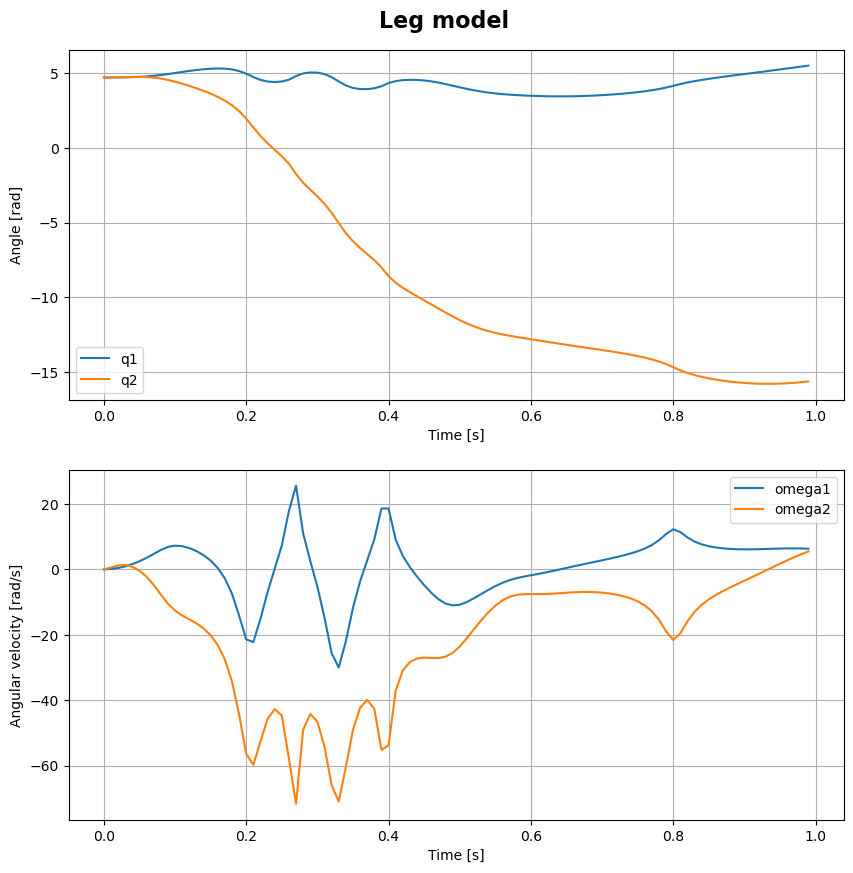

In [53]:
# use subplots to plot the results for q, omega, and M
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# add title
fig.suptitle('Leg model', fontsize=16, fontweight='bold', y=0.92)

axs[0].plot(t, q1, label='q1')
axs[0].plot(t, q2, label='q2')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Angle [rad]')
axs[0].grid()
axs[0].legend()

axs[1].plot(t, omega1, label='omega1')
axs[1].plot(t, omega2, label='omega2')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Angular velocity [rad/s]')
axs[1].grid()
axs[1].legend()

# axs[2].plot(t, M1, label='M1')
# axs[2].plot(t, M2, label='M2')
# axs[2].set_xlabel('Time [s]')
# axs[2].set_ylabel('Torque [Nm]')
# axs[2].grid()
# axs[2].legend()

fig.get_tight_layout()
plt.show()

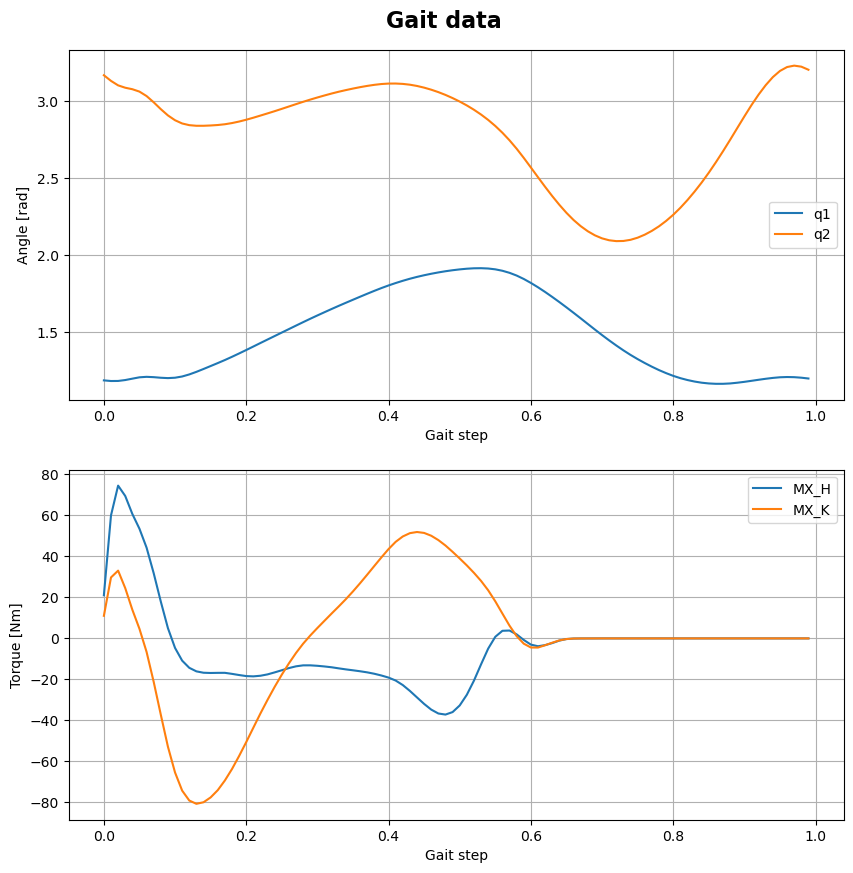

In [27]:
# plot the data from the xls file: use subplots to plot the results for q, omega, and M
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# add title
fig.suptitle('Gait data', fontsize=16, fontweight='bold', y=0.92)

axs[0].plot(gait_step, q1_gait, label='q1')
axs[0].plot(gait_step, q2_gait, label='q2')
axs[0].set_xlabel('Gait step')
axs[0].set_ylabel('Angle [rad]')
axs[0].grid()
axs[0].legend()

# plot M
axs[1].plot(gait_step, MX_H, label='MX_H')
axs[1].plot(gait_step, MX_K, label='MX_K')
axs[1].set_xlabel('Gait step')
axs[1].set_ylabel('Torque [Nm]')
axs[1].grid()
axs[1].legend()

plt.show()
